In [ ]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import time

import numpy as np
from jax import jit, grad
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload
import cartopy.crs as ccrs

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

In [ ]:
sampling = "mw"
multiresolution = True
reality = True

L = 128
N = 3
J_min = 0
#nside = L/2

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = False
if N == 1:
    axi = True

# Target map

In [ ]:
# Planet image
grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
I = pil_to_array(grayscale_pil_image).astype(np.float64)
I = np.ascontiguousarray(I[:,:-1])

L_temp = I.shape[0]
Ilm = s2fft.forward_jax(I, L_temp, reality=reality)
Ilm = Ilm[:L, L_temp-L:L_temp + L-1]

I = s2fft.inverse_jax(Ilm, L, reality=reality)
I -= np.mean(I)
I /= np.std(I)

Ilm = s2fft.forward_jax(I, L, reality=reality)

In [ ]:
def plot_map_MW_Mollweide(map_MW, figsize=(12, 8), fontsize=16, vmin=None, vmax=None,
                          central_longitude=180, title='Mollweide view - Real part',
                          fig=None, ax=None):

    if fig is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.Mollweide(central_longitude=central_longitude))
    im = ax.imshow(np.real(map_MW), transform=ccrs.PlateCarree(),
                   vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=fontsize)
    fig.colorbar(im, ax=ax, orientation='horizontal')
    return

# Plot the map
mx, mn = np.nanmax(I), np.nanmin(I)
plot_map_MW_Mollweide(I, figsize=(8, 6), vmin=-3, vmax=3)



# Wavelets

In [ ]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plt.figure(figsize=(8, 6))
plt.plot(filters[1], 'ko', label='Scaling fct')
for j in range(J):
    plt.plot(np.real(filters[0])[j, :, L-1], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

In [ ]:
# Compute the coeff of the target
if axi:
    mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm[:, L-1:], L, N, J_min, sampling, None, 
                                                reality, multiresolution, filters=filters)
    # mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)
else:
    mean, var, S1, P00, C01, C11 = scat_cov_dir(Ilm[:, L-1:], L, N, J_min, sampling, None, 
                                                reality, multiresolution, filters=filters)
    # mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)
print(mean, C01)

# Define the loss

In [ ]:
def chi2(model, data):
    return jnp.sum(jnp.square(data - model))

def func(flm):
    if axi:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_axi(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    else:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_dir(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    # Control for mean + var
    loss = jnp.abs(mean-mean_new)**2
    loss += jnp.abs(var-var_new)**2
    
    # Add S1 loss
    loss += jnp.sum(jnp.abs(S1-S1_new)**2)

    # Add P00 loss
    loss += jnp.sum(jnp.abs(P00-P00_new)**2)

    # Add C01 loss
    loss += jnp.sum(jnp.abs(C01-C01_new)**2)
    
    # Add C11 loss
    loss += jnp.sum(jnp.abs(C11-C11_new)**2)
    
    return loss

#grad_func = jit(grad(func))
grad_func = grad(func)


In [ ]:
### Initial condition
f = np.random.randn(L, 2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)
loss_0 = func(flm_start)
print(loss_0)

In [ ]:
loss_history = [loss_0]

In [ ]:
iterations = 400
momentum = 2.
for i in range(iterations):
    start = time.time()
    flm -= momentum*np.conj(grad_func(flm))
    if i % 1 == 0: 
        end = time.time()
        print(f"Iteration {i}: Loss/Loss-0 = {func(flm):.5f}/{loss_0:.5f}, Momentum = {momentum}, Time = {end - start:.2f} s")
        loss_history.append(func(flm))

# Check the synthesis

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

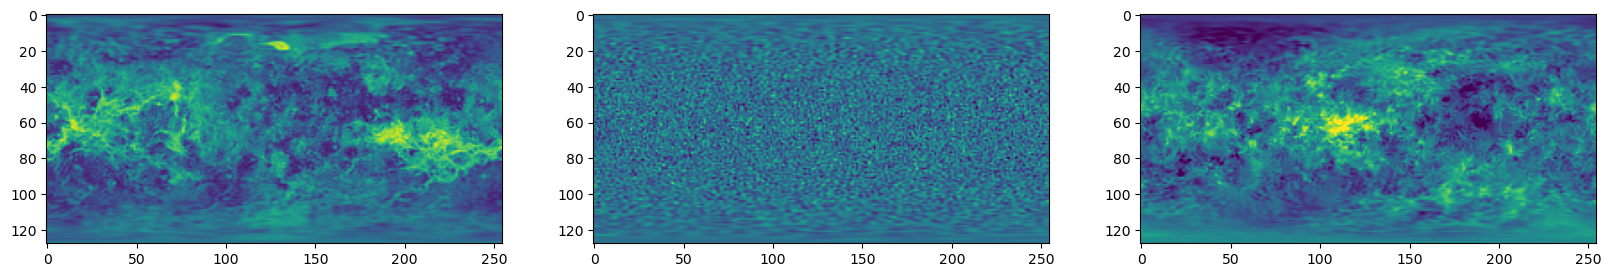

In [13]:
from matplotlib import pyplot as plt 

if reality:
    # Create and store signs 
    msigns = (-1)**jnp.arange(1,L)

    # Reflect and apply hermitian symmetry
    flm_full_end = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_end = flm_full_end.at[:,L-1:].set(flm)
    flm_full_end = flm_full_end.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_end[:, L:])*msigns, axis=-1))

    # Reflect and apply hermitian symmetry
    flm_full_start = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_start = flm_full_start.at[:,L-1:].set(flm_start)
    flm_full_start = flm_full_start.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_start[:, L:])*msigns, axis=-1))

I = s2fft.inverse_jax(Ilm, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(I, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

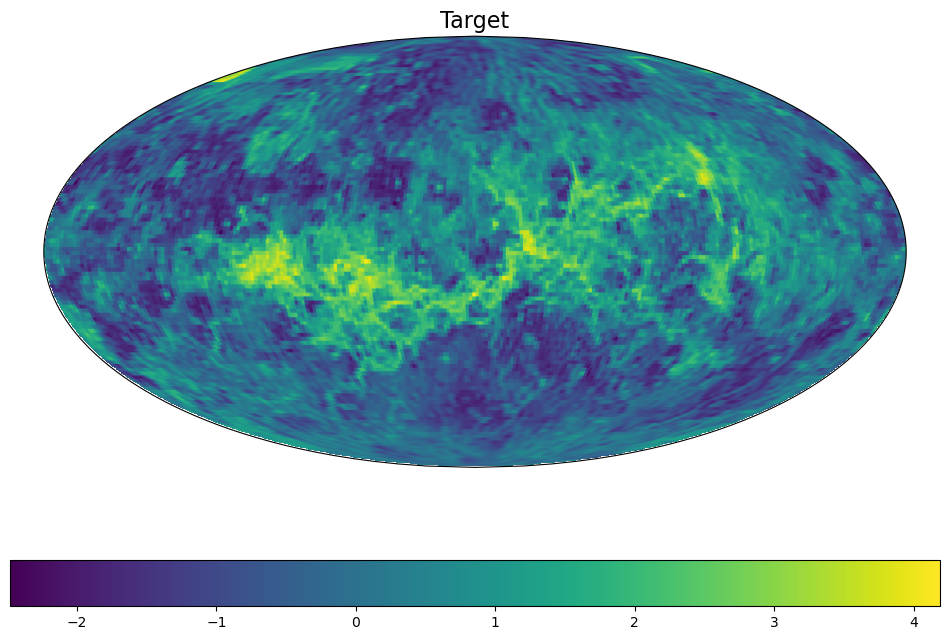

In [14]:
plot_map_MW_Mollweide(I, vmin=mn, vmax=mx, title='Target')

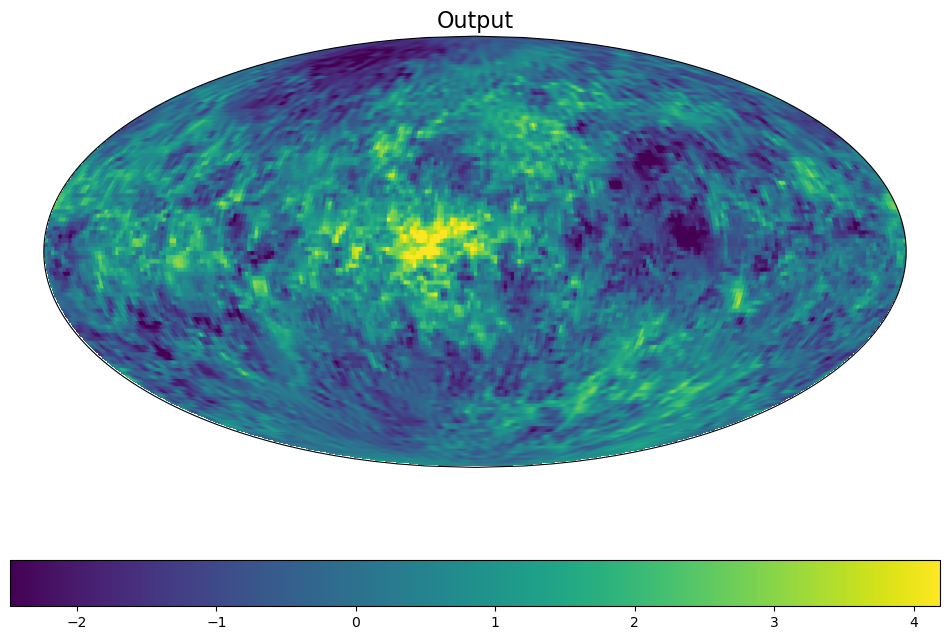

In [19]:

plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='Output', central_longitude=0)

### Power spectrum

In [16]:
def compute_ps(flm):
    return jnp.sum(jnp.abs(flm)**2,axis=-1)

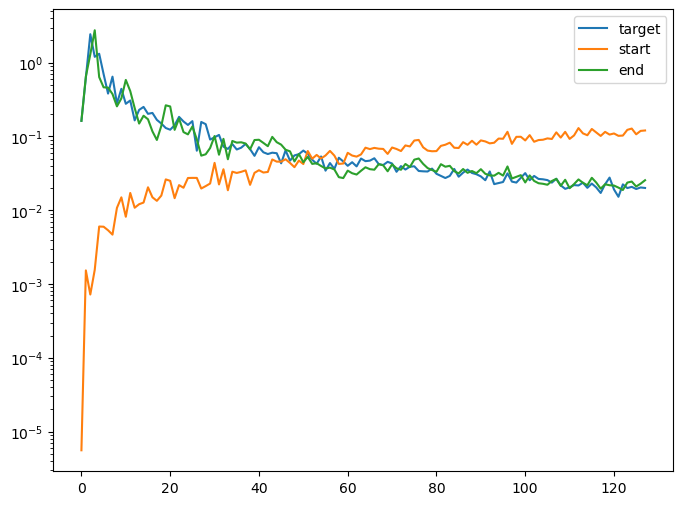

In [17]:
ps_true = compute_ps(Ilm)
ps_start = compute_ps(flm_full_start)
ps_end = compute_ps(flm_full_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_true, label="target")
plt.plot(ps_start, label="start")
plt.plot(ps_end, label="end")
plt.yscale("log")
plt.legend()

### Plot the coefficients

In [18]:
mean_start, var_start, S1_start, P00_start, C01_start, C11_start = scat_cov_axi(flm_full_start, L, N, J_min, sampling, None, 
                                                                     reality, multiresolution, filters=filters)
mean_end, var_end, S1_end, P00_end, C01_end, C11_end = scat_cov_axi(flm_full_end, L, N, J_min, sampling, None, 
                                                           reality, multiresolution, filters=filters)

ValueError: Incompatible shapes for broadcasting: (128, 255) and requested shape (128, 128)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax0, ax1, ax2, ax3 = axs.ravel()

ax0.plot(np.real(S1), label='Target')
ax0.plot(np.real(S1_start), label='Initial')
ax0.plot(np.real(S1_end), label='Output')
ax0.legend()
ax0.set_ylabel('S1')

ax1.plot(np.real(P00), label='Target')
ax1.plot(np.real(P00_start), label='Initial')
ax1.plot(np.real(P00_end), label='Output')
ax1.legend()
ax1.set_ylabel('P00')

ax2.plot(np.real(C01), label='Target')
ax2.plot(np.real(C01_start), label='Initial')
ax2.plot(np.real(C01_end), label='Output')
ax2.legend()
ax2.set_ylabel('C01')

ax3.plot(np.real(C11), label='Target')
ax3.plot(np.real(C11_start), label='Initial')
ax3.plot(np.real(C11_end), label='Output')
ax3.legend()
ax3.set_ylabel('C11')